# MNIST Image Classification Using LeNet (Tensorflow Backend)
In this example, we are going to demonstrate how to train an MNIST image classification model using a LeNet model architecture and TensorFlow backend. 

## Import the required libraries

In [1]:
import tensorflow as tf
import fastestimator as fe
import numpy as np
import matplotlib.pyplot as plt
import tempfile

from fastestimator.util import BatchDisplay, GridDisplay

In [2]:
#training parameters
epochs = 2
batch_size = 32
train_steps_per_epoch = None
eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

## Step 1 - Data and `Pipeline` preparation
In this step, we will load MNIST training and validation datasets and prepare FastEstimator's pipeline.

### Load dataset 
We use a FastEstimator API to load the MNIST dataset and then get a test set by splitting 50% of the data off of the evaluation set. 

In [3]:
from fastestimator.dataset.data import mnist

train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)

### Set up a preprocessing pipeline
In this example, the data preprocessing steps include adding a channel to the images (since they are grey-scale) and normalizing the image pixel values to the range [0, 1]. We set up these processing steps using `Ops`. The `Pipeline` also takes our data sources and batch size as inputs. 

In [4]:
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       batch_size=batch_size,
                       ops=[ExpandDims(inputs="x", outputs="x_out"), 
                            Minmax(inputs="x_out", outputs="x_out")])

### Validate `Pipeline`
In order to make sure the pipeline works as expected, we need to visualize its output. `Pipeline.get_results` will return a batch  of pipeline output to enable this:  

In [5]:
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]

print("the pipeline input data size: {}".format(data_xin.numpy().shape))
print("the pipeline output data size: {}".format(data_xout.numpy().shape))
print("the maximum pixel value of output image: {}".format(np.max(data_xout.numpy())))
print("the minimum pixel value of output image: {}".format(np.min(data_xout.numpy())))

the pipeline input data size: (32, 28, 28)
the pipeline output data size: (32, 28, 28, 1)
the maximum pixel value of output image: 1.0
the minimum pixel value of output image: 0.0


2022-05-17 18:39:52.069204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 18:39:52.548658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


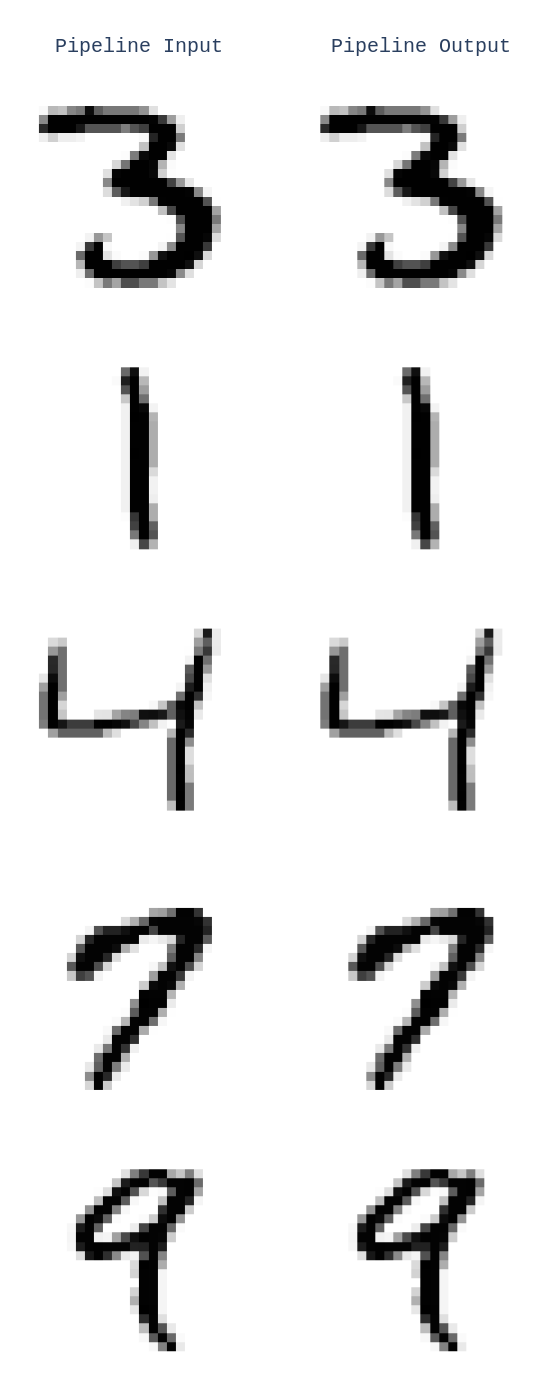

In [6]:
num_samples = 5
indices = np.random.choice(batch_size, size=num_samples, replace=False)
inputs = tf.gather(data_xin.numpy(), indices)
outputs = tf.gather(data_xout.numpy(), indices)

fig = GridDisplay([BatchDisplay(image=inputs, title='Pipeline Input'),
                   BatchDisplay(image=outputs, title='Pipeline Output')
                  ])
fig.show()

## Step 2 - `Network` construction
**FastEstimator supports both PyTorch and TensorFlow, so this section could use either backend.** <br>
We are going to only demonstrate the TensorFlow backend in this example.

### Model construction
Here we are going to import one of FastEstimator's pre-defined model architectures, which was written in TensorFlow. We create a model instance by compiling our model definition function along with a specific model optimizer.

In [7]:
from fastestimator.architecture.tensorflow import LeNet

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

### `Network` definition
We are going to connect the model and `Ops` together into a `Network`. `Ops` are the basic components of a `Network`. They can be logic for loss calculation, model update rules, or even models themselves. 

In [8]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp


network = fe.Network(ops=[
        ModelOp(model=model, inputs="x_out", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce")
    ])

2022-05-17 18:39:53.965393: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Step 3 - `Estimator` definition and training
In this step, we define an `Estimator` to connect our `Network` with our `Pipeline` and set the `traces` which compute accuracy (`Accuracy`), save the best model (`BestModelSaver`), and change the model learning rate over time (`LRScheduler`).

In [9]:
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy


traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="accuracy", save_best_mode="max"),
    LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step, cycle_length=3750, init_lr=1e-3))
]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch)

estimator.fit() # start the training process

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.


2022-05-17 18:39:58.639145: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-17 18:39:59.830141: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


FastEstimator-Start: step: 1; logging_interval: 100; num_device: 1;
FastEstimator-Train: step: 1; ce: 2.3435714; model_lr: 0.0009999998;
FastEstimator-Train: step: 100; ce: 0.4765919; model_lr: 0.0009982482; steps/sec: 321.43;
FastEstimator-Train: step: 200; ce: 0.20118365; model_lr: 0.000993005; steps/sec: 436.99;
FastEstimator-Train: step: 300; ce: 0.099995025; model_lr: 0.0009843073; steps/sec: 427.64;
FastEstimator-Train: step: 400; ce: 0.0135647105; model_lr: 0.000972216; steps/sec: 396.01;
FastEstimator-Train: step: 500; ce: 0.21389233; model_lr: 0.00095681596; steps/sec: 437.99;
FastEstimator-Train: step: 600; ce: 0.11859661; model_lr: 0.0009382152; steps/sec: 451.64;
FastEstimator-Train: step: 700; ce: 0.0150666125; model_lr: 0.0009165442; steps/sec: 437.15;
FastEstimator-Train: step: 800; ce: 0.19784231; model_lr: 0.00089195487; steps/sec: 411.11;
FastEstimator-Train: step: 900; ce: 0.09315811; model_lr: 0.00086461985; steps/sec: 415.99;
FastEstimator-Train: step: 1000; ce: 0.

## Model testing
`Estimator.test` triggers model testing using the test dataset that was specified in `Pipeline`. We can evaluate the model's accuracy on this previously unseen data. 

In [10]:
estimator.test()

FastEstimator-Test: step: 3750; epoch: 2; accuracy: 0.991; ce: 0.02567655;


## Inferencing
Now let's run inferencing on several images directly using the model that we just trained. 
We randomly select 5 images from the testing dataset and infer them image by image by leveraging `Pipeline.transform` and `Network.transform`:

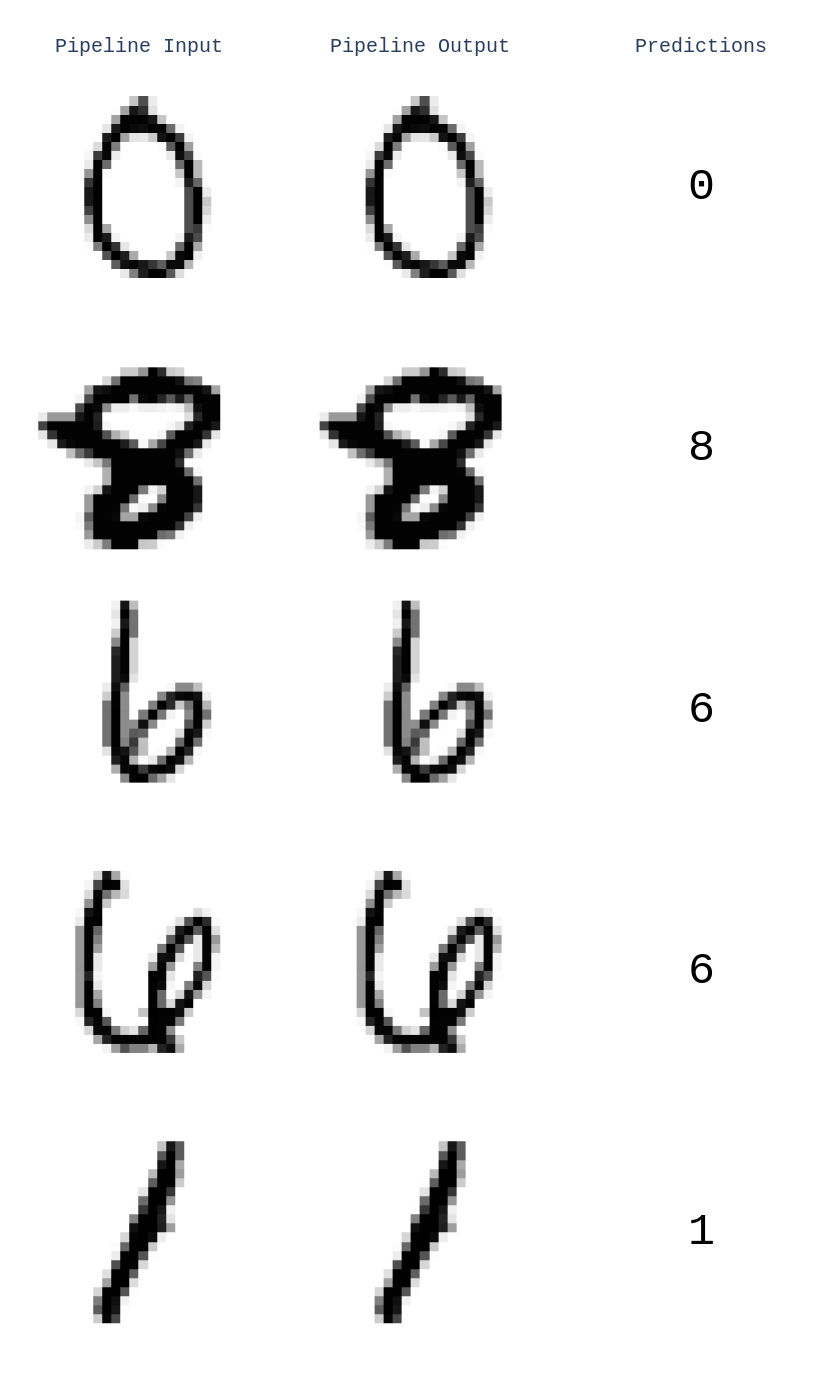

In [11]:
num_samples = 5
indices = np.random.choice(batch_size, size=num_samples, replace=False)

inputs = []
outputs = []
predictions = []

for idx in indices:
    inputs.append(test_data["x"][idx])
    data = {"x": inputs[-1]}
    
    # run the pipeline
    data = pipeline.transform(data, mode="infer") 
    outputs.append(data["x_out"].squeeze(axis=(0,3)))
    
    # run the network
    data = network.transform(data, mode="infer")
    predictions.append(np.argmax(data["y_pred"].numpy().squeeze(axis=(0))))

fig = GridDisplay([BatchDisplay(image=np.stack(inputs), title="Pipeline Input"),
                   BatchDisplay(image=np.stack(outputs), title="Pipeline Output"),
                   BatchDisplay(text=np.stack(predictions), title="Predictions")
                  ])
fig.show()